In [7]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

def calculate_similarity(row1, row2, weights, method="euclidean"):
    """
    Calculate similarity between two rows using specified method and weights
    
    Parameters:
    row1, row2: Pandas Series containing row data (first column is excluded)
    weights: Numpy array of weights for each feature
    method: 'euclidean' or 'cosine'
    
    Returns:
    float: Similarity score
    """
    if weights is None:
        weights = np.ones(len(row1))


    if method == "euclidean":
        # Skip first column (typically an ID column)
        scaled_differences = (row1.iloc[0:] - row2.iloc[0:])* weights
        return np.sqrt(np.sum(scaled_differences**2))
    
    elif method == "cosine":
        scaled_row1 = row1.iloc[1:] * weights
        scaled_row2 = row2.iloc[1:] * weights
        return 1 - np.sum(scaled_row1 * scaled_row2) / (np.sqrt(np.sum(scaled_row1**2)) * np.sqrt(np.sum(scaled_row2**2)))
    
    else:
        raise ValueError("Unsupported similarity method")

def create_similarity_matrix(df1, df2, weights, method="euclidean"):
    """
    Calculate similarity between each row in df1 and each row in df2
    
    Parameters:
    df1, df2: Pandas DataFrames
    weights: Numpy array of weights for each feature
    method: 'euclidean' or 'cosine'
    
    Returns:
    numpy.ndarray: Matrix of similarity scores
    """
    similarity_matrix = np.zeros((len(df1), len(df2)))
    
    for i in range(len(df1)):
        for j in range(len(df2)):
            similarity_matrix[i, j] = calculate_similarity(df1.iloc[i], df2.iloc[j], weights, method=method)
    
    return similarity_matrix

def get_top_n_similarities(similarity_matrix, df1, df2, n=5):
    """
    For each row in df1, find the top n most similar rows in df2
    
    Parameters:
    similarity_matrix: numpy.ndarray of similarity scores
    df1, df2: Pandas DataFrames
    n: Number of top matches to return
    
    Returns:
    pandas.DataFrame: DataFrame with player_id from df1, player_id from df2, and similarity scores
    """
    result_rows = []
    
    for i in range(similarity_matrix.shape[0]):
        # For each row, get indices of top n smallest values
        # (for euclidean distance, smaller means more similar)
        top_indices = np.argsort(similarity_matrix[i])[:n]
        top_values = np.sort(similarity_matrix[i])[:n]
        
        # Get the corresponding player IDs from df2
        for j, (idx, val) in enumerate(zip(top_indices, top_values)):
            result_rows.append({
                'ID.x': df1.iloc[i]['ID.x'],
                'ID.y': df2.iloc[idx]['ID.x'],
                'similarity': val
            })
    
    return pd.DataFrame(result_rows)


def convert_to_percentile(result_df):
    """
    Convert similarity values to percentile scale (0-1) where:
    - Smallest similarity value (most similar) becomes 1.0
    - Largest similarity value (least similar) becomes 0.0
    
    Parameters:
    result_df: pandas DataFrame with a 'similarity' column
    
    Returns:
    pandas DataFrame: Original dataframe with added 'percentile' column
    """
    # Get the min and max similarity values
    min_sim = result_df['similarity'].min() * 100
    max_sim = result_df['similarity'].max() * 100
    
    # Calculate the range
    sim_range = max_sim - min_sim
    
    # If all values are the same, set percentile to 1
    if sim_range == 0:
        result_df['percentile'] = 100
        return result_df
    
    # Calculate the relative position in the range (0-1)
    # Then invert so smallest similarity becomes 1
    result_df['similarity'] = round(100 - ((result_df['similarity'] * 100 - min_sim) / sim_range) * 100, 2)
    
    return result_df

In [3]:
current_year = pd.read_csv('current_year_rb.csv').drop(columns = ['Last_Season'])
current_year.set_index('ID.x')
full_list = pd.read_csv('full_list_prospects_rb.csv').drop(columns = ['target', 'Diff', 'Last_Season'])
full_list.set_index('ID.x')
print(current_year.columns)

current_noid = current_year.drop(columns=['ID.x'])
print(current_noid.columns)
full_noid = full_list.drop(columns=['ID.x'])
print(full_noid.columns)

Index(['ID.x', 'predicted_label', 'min_label', 'mean_label', 'max_label',
       'Seasons', 'Attempts', 'ForcedMissedTackleRate', 'ExplosiveRate', 'TDP',
       'YardsAfterContact', 'YPRR', 'WAR', 'RushWAR', 'RecWAR',
       'best_Attempts', 'best_ForcedMissedTackleRate', 'best_ExplosiveRate',
       'best_TDP', 'best_YardsAfterContact', 'best_YPRR', 'best_WAR',
       'best_RushWAR', 'best_RecWAR', 'worst_Attempts',
       'worst_ForcedMissedTackleRate', 'worst_ExplosiveRate', 'worst_TDP',
       'worst_YardsAfterContact', 'worst_YPRR', 'worst_WAR', 'worst_RushWAR',
       'worst_RecWAR', 'Strength_Power 5', 'ht_in', 'wt', 'arm_in', 'wing_in',
       'c_reps', 'c_10y', 'c_40y', 'c_vj_in', 'c_bj_in', 'c_3c', 'c_ss20',
       'est_40y'],
      dtype='object')
Index(['predicted_label', 'min_label', 'mean_label', 'max_label', 'Seasons',
       'Attempts', 'ForcedMissedTackleRate', 'ExplosiveRate', 'TDP',
       'YardsAfterContact', 'YPRR', 'WAR', 'RushWAR', 'RecWAR',
       'best_Attempts

In [5]:
weights = np.array([1, 1, 1, 1,
                    0, 1, 2, 2, 1,
                    2, 2, 1, 1, 1,
                    1, 2, 2,
                    1, 2, 1, 1, 
                    1, 1, 1,
                    2, 2, 1,
                    2, 1, 1, 1, 
                    1, 0, 3, 3, 0, 0,
                    0, 3, 3, 3, 3, 3, 3, 
                    3
                    ]) 
similarity_matrix = create_similarity_matrix(current_noid, full_noid, weights, method="euclidean")

In [8]:
result_df = get_top_n_similarities(similarity_matrix, current_year, full_list, n=5)
result_df = convert_to_percentile(result_df)
result_df.to_csv('similarity_list.csv')

K = 2: Silhouette Score = 0.176
K = 3: Silhouette Score = 0.153
K = 4: Silhouette Score = 0.120
K = 5: Silhouette Score = 0.105
K = 6: Silhouette Score = 0.108
K = 7: Silhouette Score = 0.109
K = 8: Silhouette Score = 0.101
K = 9: Silhouette Score = 0.106
K = 10: Silhouette Score = 0.099
K = 11: Silhouette Score = 0.091
K = 12: Silhouette Score = 0.093
K = 13: Silhouette Score = 0.092
K = 14: Silhouette Score = 0.087
K = 15: Silhouette Score = 0.088

Best k based on silhouette score: 2


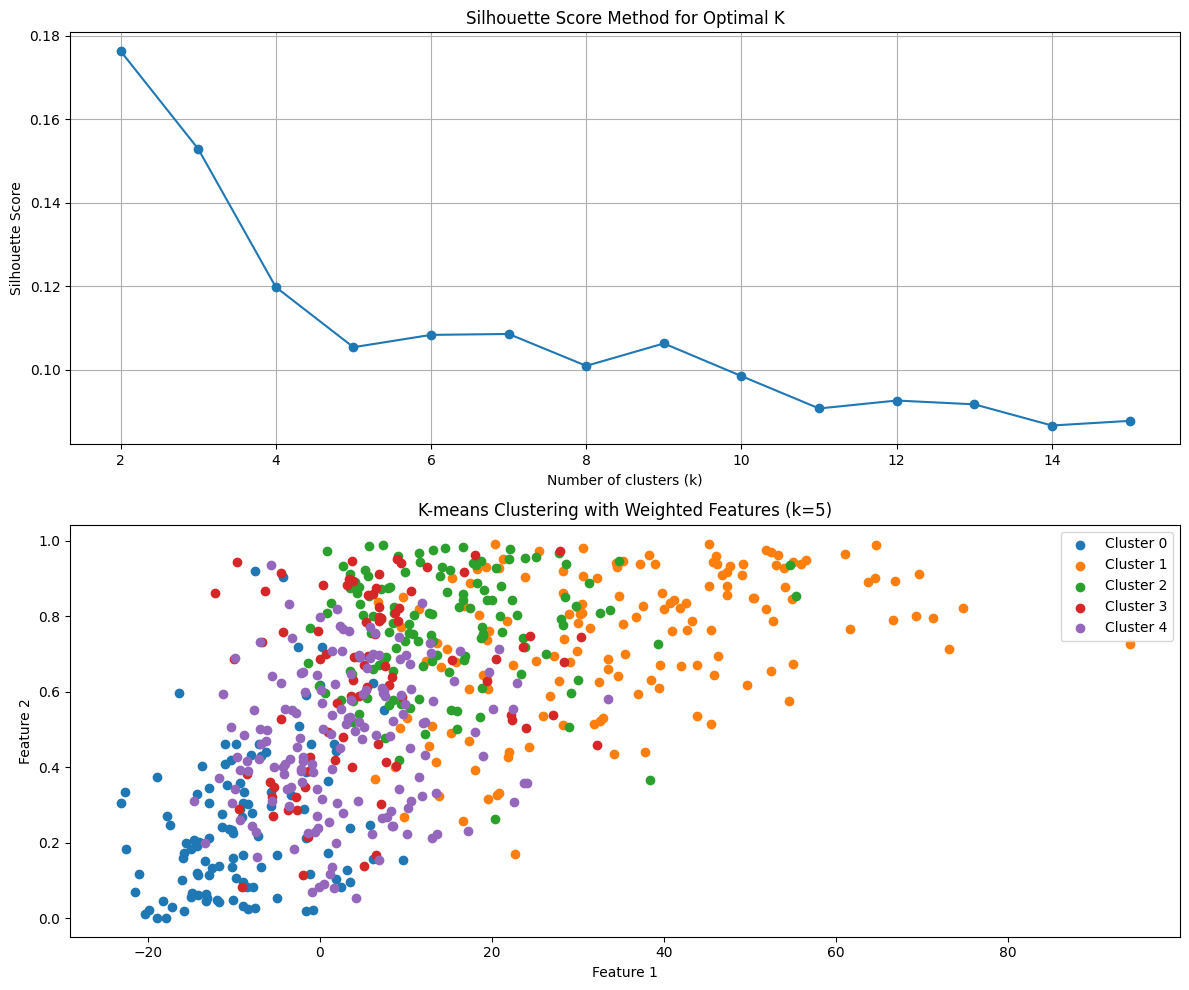

In [10]:
output_df = pd.concat([current_year, full_list])
full_df = pd.concat([current_noid, full_noid])


# Create a copy of the dataframe to apply weights
weighted_df = full_df.copy()

# Standardize the weighted features
scaler = StandardScaler()
weighted_scaled_data = scaler.fit_transform(weighted_df)

columns = full_df.columns


# Apply weights by multiplying each feature by its weight
for i in range(len(weights)):
    feature = columns[i]
    weight = weights[i]
    weighted_df[feature] = full_df[feature] * weight


# Function to find optimal k using silhouette score
def find_optimal_k(data, max_k):
    silhouette_scores = []
    k_values = range(2, max_k + 1)
    
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(data)
        
        # Calculate silhouette score
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"K = {k}: Silhouette Score = {silhouette_avg:.3f}")
        
    # Find the best k
    best_k = k_values[np.argmax(silhouette_scores)]
    return best_k, k_values, silhouette_scores

# Find optmal k
max_k = 15
best_k, k_values, silhouette_scores = find_optimal_k(weighted_scaled_data, max_k)
print(f"\nBest k based on silhouette score: {best_k}")

best_k = 5

# Perform k-means with the optimal k
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(weighted_scaled_data)

# Add cluster labels to original dataframe
output_df['cluster'] = cluster_labels
output_df = output_df[['cluster'] + [col for col in output_df.columns if col != 'cluster']]


# Plot the results (using the first two features)
plt.figure(figsize=(12, 10))

# Plot 1: Silhouette scores
plt.subplot(2, 1, 1)
plt.plot(k_values, silhouette_scores, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method for Optimal K')
plt.grid(True)

# Plot 2: Clustering result
plt.subplot(2, 1, 2)
for cluster in range(best_k):
    cluster_data = output_df[output_df['cluster'] == cluster]
    plt.scatter(
        cluster_data['predicted_label'], 
        cluster_data['ExplosiveRate'],
        label=f'Cluster {cluster}'
    )

# plt.scatter(
#     kmeans.cluster_centers_[:, 0] / weights[0],  # Adjust centers back
#     kmeans.cluster_centers_[:, 1] / weights[47],
#     s=200,
#     marker='X',
#     c='black',
#     label='Centroids'
# )
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title(f'K-means Clustering with Weighted Features (k={best_k})')
plt.legend()
plt.tight_layout()
plt.show()
